# Hands-on Lab: Cats vs Dogs Image Classifiers

Welcome to the hands-on lab! You will be using the famous `Cats vs Dogs` dataset to train a model that can classify images of dogs from images of cats. For this, you will use Convolutional Neural Network in Tensorflow and leverage Keras image preprocessing utilities.

You will also create some helper functions to move the images around the filesystem so if you are not familiar with the `os` module be sure to take a look a the [docs](https://docs.python.org/3/library/os.html).

Let's get started!

In [2]:
# Import the necessary libraries
import os
import zipfile
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.model_selection import train_test_split 
from random import randint

Download the dataset from its original source by running the cell below. 

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [ ]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [3]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# Deletes corrupt images files
class_names = ['Cat', 'Dog']
for _class in class_names:
  folder_path = os.path.join(source_path, _class)
  for img_file in os.listdir(folder_path):
    path = os.path.join(folder_path, img_file)
    try:
      image=tf.keras.preprocessing.image.load_img(path)
    except:
      print(f'Removing {img_file} in {_class}')
      os.remove(path)

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

find: /tmp/PetImages/: No such file or directory


/opt/homebrew/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


There are 12499 images of dogs.
There are 12499 images of cats.


In [102]:
def preview_sample(SOURCE_DIR, NUM_OF_IMGS):
  """
  Preview sample images from directories
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    NUM_OF_IMGS (int): number sample of images to preview
    
  Returns:
    None
  """
  for i in range(NUM_OF_IMGS):
    img_class = random.choice(['Cat', 'Dog'])
    folder_path = os.path.join(SOURCE_DIR, img_class)
    img_path = os.listdir(folder_path)
    img = matplotlib.image.imread(os.path.join(folder_path, random.choice(img_path)))
    plt.imshow(img)
    plt.show()


Displaying random sample images from dataset

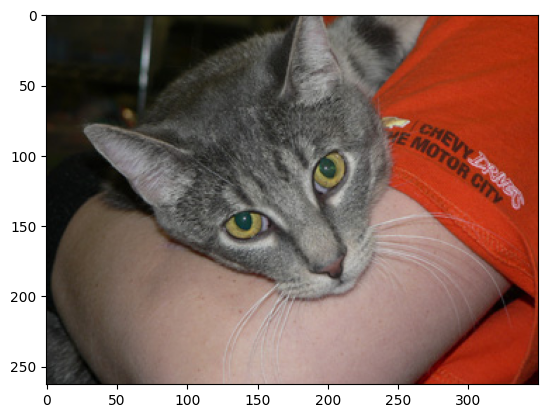

In [103]:
img_path = preview_sample(source_path, 1)


Read Images and it's labels

In [ ]:
def load_dataset(SOURCE_DIR, CLASS_NAME, TARGET_SIZE):
  """
  Load images and labels from directories
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    CLASS_NAME (array_like): Array of class names
    TARGET_SIZE (array_like): Dimension of the images
    
  Returns:
    array_like: Images data
    array_like: Images label
  """

  dataset = []
  label = []

  for _class in CLASS_NAME:
    tmp_dataset = []
    folder_path = os.path.join(SOURCE_DIR, _class)
    for img_file in os.listdir(folder_path):
      path = os.path.join(folder_path, img_file)
      try:
        image=tf.keras.preprocessing.image.load_img(path, color_mode='rgb', 
              target_size=TARGET_SIZE)
      except:
        print(f'File {img_file} in {_class} is corrupted')
      else:
        image=tf.keras.preprocessing.image.load_img(path, color_mode='rgb', 
            target_size=TARGET_SIZE)
        image=np.array(image)
        tmp_dataset.append(image)
        del image
        label.append(_class)
    dataset.append(np.asarray(tmp_dataset))
    del tmp_dataset
  dataset = np.concatenate(dataset, axis=0)
  
  # Label converter
  labels = []
  for _label in label:
    labels.append(CLASS_NAME.index(_label))
    
  # One hot encoder for multiple classes
  if len(CLASS_NAME) > 2:
    labels = tf.keras.utils.to_categorical(labels).astype(int)
  del label

  return dataset, np.asarray(labels)

In [ ]:
class_name = ['Cat', 'Dog']
dataset, labels = load_dataset(source_path, class_name, (150,150))

In [ ]:
# Checking dataset and labels shape
print(dataset.shape)
print(labels.shape)

In [ ]:
# Train test split
train_data, test_data, label_train, label_test = train_test_split(dataset, labels, train_size=0.9, shuffle=True)

In [ ]:
# Checking train, test, and it's label shape
print(train_data.shape)
print(label_train.shape)
print(test_data.shape)
print(label_test.shape)

Defining the CNN Model

In [ ]:
def create_model():

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Lambda(lambda x: x/255, input_shape=(150, 150, 3)), # Normalize the input images
      tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # tf.keras.layers.BatchNormalization(), # Uncomment to use BatchNormalization
      tf.keras.layers.GlobalAveragePooling2D(),
      # tf.keras.layers.Flatten(), # If you use GlobalAveragePooling, comment this line
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.8), # Uncomment to use dropout
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
    

  return model

In [ ]:
# Get the untrained model
model = create_model()

In [ ]:
# Display model architecture
model.summary()

In [ ]:
# Train the model
# Note that this may take some time.
history = model.fit(train_data, label_train,batch_size=64, validation_split=0.1, epochs=5)

Once training has finished, you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

In [ ]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label='acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Test our model

In [ ]:
def make_prediction(model, data, label, CLASS_NAME):
  """
  Preview sample images from directories
  
  Args:
    model: trained model
    data (array-like): data to predict
    label (array-like) : true label of data
    CLASS_NAME (array_like): Array of class names
    
  Returns:
    None
  """

  idx = randint(0, label.shape[0]-1)
  x = np.expand_dims(data[idx], axis=0)
  y_pred = model.predict(x)
  y_pred = round(y_pred.flatten()[0])
  plt.imshow(data[idx])
  plt.xlabel(f'Predicted class: {CLASS_NAME[y_pred]}\nActual class: {CLASS_NAME[label[idx]]}')
  plt.show()


In [ ]:
make_prediction(model, test_data, label_test, class_name)

Inspect our features extractor

In [ ]:
def visualize_layer(model, data):
  """
  Feature extractor inspection and visualizer
  
  Args:
    model: trained model
    data (array-like): data to predict
    
  Returns:
    None
  """  
  successive_outputs = [layer.output for layer in model.layers]
  visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs[1:])

  idx = randint(0, data.shape[0]-1)
  x = np.expand_dims(data[idx], axis=0)

  successive_feature_maps = visualization_model.predict(x)

  # let's map the layers of this model with their name
  layer_names = [layer.name for layer in model.layers]

  # plot everything
  for layer_name, feature_map in zip(layer_names[1:], successive_feature_maps):
    
    if len(feature_map.shape) == 4: # if it is a conv or pooling layer
      n_features = feature_map.shape[-1]  # n features
      size       = feature_map.shape[ 1]  # shape
      
      # create a grid to display the data
      display_grid = np.zeros((size, size * n_features))
      
      # some post-processing
      for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x

      # show the chart
      scale = 20. / n_features
      plt.figure( figsize=(scale * n_features, scale) )
      plt.title ( layer_name )
      plt.grid  ( False )
      plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

In [ ]:
visualize_layer(model, test_data)